### 1. BACE

"Bayesian agglomerative clustering engine" (Bowman, 2012) http://arxiv.org/pdf/1201.3867v5.pdf

Algorithm:
1. Merge the pair of connected states whose Bayes factor for keeping them separate vs. merging them is minimal.
2. Repeat.

<img src="BACE_dendrogram.jpg" width="25%" height="25%">

#### Closed-form expression for Bayes factor
$$ \log \frac{p(i,j\text{ different}|C)}{p(i,j \text{ same}|C)} \approx \hat{C}_i D_{KL}(p_i \| q) + \hat{C}_j D_{KL}(p_j \| q)$$

where
- $C$ is the transition count matrix
- $\hat{C}_i$ is the number of transitions observed from state $i$
- $D_{KL}(p\| q)$ is the Kullback Liebler divergence, $D_{KL}(p\| q) \equiv \sum_i p_i \log \frac{p_i}{q_i}$
- $p_i$ is $T_{i,\cdot}$
- $q=\frac{\hat{C}_ip_i + \hat{C}_j p_j}{\hat{C}_i+\hat{C}_j}$

### 2. Bayesian rose trees
http://arxiv.org/pdf/1203.3468.pdf

**Setup:**

Bayesian hierarchical clustering approximately solves:
$$ T^* = \underset{T\in \mathcal{H}}{\text{argmax }} p(\mathcal{D} | T)$$
i.e. search for the cluster tree $T^*$ that maximizes the marginal likelihood of the data, within some hypothesis class of cluster trees $\mathcal{H}$.

**Key idea:**

Hierarchical clustering typically considers only binary cluster trees, i.e. the merge operations considered in the greedy search always create a new node with 2 children, which results in spurious "cascading" behavior. We would instead like to consider arbitrary branching structure, so that we are not forced to introduce spurious orderings over indistinguishable subtrees.

<img src="rose_tree.jpg" width="50%" height="50%">

**Details:**

Agglomerative clustering is greedy search over binary trees, iteratively finding the best pair of subtrees to join.

- **Join** $i,j$: create a new node whose children are the pair of subtrees considered: $T_m = \{T_i,T_j\}$

To generalize to arbitrary branching structures, we just have to consider a couple new merge operations at each iteration:
- **Absorb** $i,j$: tree $j$ is added as a child of tree $i$: $T_m = \text{ch}(T_i)\cup\{T_j\}$
    - Asymmetric, so we'll also consider **Absorb** $j,i$
- **Collapse** $i,j$: merge the roots of both trees $T_m = \text{ch}(T_i)\cup\text{ch}(T_j)$

<img src="merges.jpg" width="50%" height="50%">

We can now greedily search over arbitrary branching structures.

In Bayesian clustering, our search is aimed at maximizing the marginal likelihood of a tree, $p(\mathcal{D} | T)$, and we may need tricks for efficiently computing, approximating, or lower-bounding this quantity.

### 3. Bayesian rose trees for coarse-graining?

Can we extend BACE to use alternate branching structures?

To do that, we'll need to create a model of *hierarchies*, not just a model of *partitions.*

**Notes / observations:**
- BACE uses the (approximate) likelihood of a partition to greedily search over partitions. The BACE Bayes factor term always favors finer partitions.
<img src="bace_bayes_factors.jpg" width="50%" height="50%">
    - The paper suggests to look for the biggest jump here, but by itself the model selection term will *always increase as you allow more states*. We would like to define a term that allows us to automatically select the appropriate number of states.
- The BACE Bayes factor is actually used to select a "flat" partition. Although a cluster tree is obtained, we inspect the tree only to select the number of macrostates, and their memberships.
- Why does the model comparison term only consider transitions *out* of a state? Why not consider transitions *into* the state as well?
- When approximating the log model evidence, we're making a couple approximations, including using maximum likelihood point estimates of the transition matrix: should probably sample / integrate over plausible transition matrices instead, to see how good this approximation is. I expect that the approximations are pretty accurate / sampling will introduce more difficulty than it's worth in practice, but it would be good to show that explicitly.

**Brainstorming alternate models:**
- What do we mean by a "hierarchical" Markov process?
    - Default interpretation: The transition matrix is "hierarchical," meaning that it is approximately a block matrix, whose blocks are also ~ block matrices, and so on. At the top level, you might have a 2-by-2 transition matrix. Each of its four blocks is then considered its own transition matrix, i.e. for all states within the block, we ignore transitions out of the block.
- Does a single counts matrix suffice? Or can we do better by looking at counts-matrices at more than one lag-time? 
- Will need to write down the likelihood of a multiresolution model: Markovian over macrostates, mesostates within macrostates, microstates within mesostates, etc., along with coupling terms between levels (i.e. conditional probability of a microstate, given that you're in a mesostate). As a "limiting" case, we have a single macrostate, containing all microstates as children. To compute the marginal likelihood of a hierarchy, we integrate over all the individual transition matrices.
- Possible to give up on hierarchy. The main reason we're looking at it is just to have a more convenient way infer the number of macrostates. Do we really need the hierarchy? If not, we could instead use an infinite HMM or something, to automatically discover the number of hidden states: http://mlg.eng.cam.ac.uk/zoubin/papers/ihmm.pdf
- Use a different objective function over cluster trees, instead of the marginal likelihood:
    - What would be the multiresolution version of the "variational approach?" Perhaps:
        - flat product of component metastabilities. For each partition level, construct a transition matrix, compute its trace, then compute a product of these over all partition levels.
        - "Recursive" product of the fractional metastabilities at each level. I.e. when computing the trace of the coarse-grained transition matrix $T$, each self-transition probability $T_{ii}$ is computed using the lower levels. Base case: all leaves are microstates.
    - Some heuristic estimate of the "simplicity" of the hierarchical tree, minus the loss incurred by coarse-graining. The second term might be some norm on the difference between the blockwise-constant "coarse-grained" matrix and the full matrix.

**Other related work:**
- "Constructing multi-resolution MSMs to elucidate RNA hairpin folding mechanisms" (Huang, Yao, Bowman, Sun, Guibas, Carlsson, Pande, 2010) http://psb.stanford.edu/psb-online/proceedings/psb10/huang.pdf 

    Abstract: "The procedure to build MSMs using SHC is as follows. (1) Partition the conformations into a large number of states, called microstates, according to their structural similarity. An approximate K-centers clustering algorithm[20] is used here as it gives states with approximately uniform size, resulting in a correlation between the population of each state and its density. (2) Split the microstates into n density levels ordered from high to low density (L= {L1, … Ln}) such that each level contains approximately the same number of conformations. Then construct super density level sets Si, where 12 1 ... i SLL L L = ∪ ∪∪ i− i . Thus each super density level contains all previous levels . (3) Within each super density level (Si), perform spectral clustering to group kinetically related microstates. Metastable regions are better separated at high density super levels, since most of the fuzzy microstates in the transition region are excluded at these levels. Now, build a graph representing the connectivity of the states across super density levels. Then generate gradient flows along the edges of the graph from low to high density levels. Each attraction node (or attractive basin) where the gradient flow ends is assigned to a new metastable state. (4) Assign every microstate not belonging to an attraction node to the metastable state it has the largest transition probability to. Thus we have a complete state decomposition for an MSM. Furthermore, this procedure may be repeated with different super density level sets to construct MSMs at different resolutions. The larger the number of super density levels, the finer the resolution and the larger the number of metastable states in the final MSM. 1 2... i SS S ⊆ ⊆"
    
- "Asymptotic analysis of multiscale Markov chain" (Wei Zhang, 2016) http://arxiv.org/pdf/1512.08944v2.pdf
- "Hierarchical multiscale markov transition model..." (Patil and Tailie, 2001) http://sites.stat.psu.edu/~gpp/pdfs/TR2000-0603.pdf

In [2]:
from msmbuilder.example_datasets import AlanineDipeptide
trajs = AlanineDipeptide().get().trajectories
from msmbuilder.cluster import MiniBatchKMedoids
kmeds = MiniBatchKMedoids(n_clusters=100,metric='rmsd',max_iter=10)
kmeds.fit(trajs)

MiniBatchKMedoids(batch_size=100, max_iter=10, max_no_improvement=10,
         metric='rmsd', n_clusters=100, random_state=None)

In [3]:
dtrajs = kmeds.transform(trajs)

In [4]:
import pyemma

In [5]:
msm = pyemma.msm.estimate_markov_model(dtrajs,1)

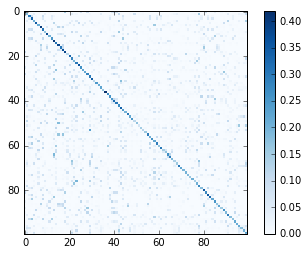

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(msm.transition_matrix,cmap='Blues',interpolation='none')
plt.colorbar()

In [7]:
lags=range(10)+range(10,101)[::10]
its = pyemma.msm.its(dtrajs,lags,nits=10)

estimating MaximumLikelihoodMSM: 100% (20/20) [####################] eta 00:01 /21-03-16 13:32:49 pyemma.msm.estimators.implied_timescales.ImpliedTimescales[0] WARNING  Estimation has failed at lagtimes: [0]. Run single-lag estimation at these lags to track down the error.


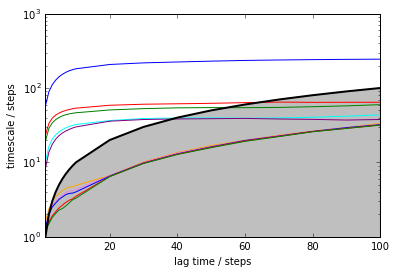

In [8]:
pyemma.plots.plot_implied_timescales(its)

In [9]:
C = msm.count_matrix_active?

In [ ]:
C = msm.count_matrix_active

In [10]:
C = msm.count_matrix_active

In [11]:
from scipy.stats import entropy as kl_div

def BACE_bayes_factor(C,i,j):
    C_hat = C.sum(1)
    T = C / C_hat[:,None]

    q = (C_hat[i]*T[i] + C_hat[j]*T[j]) / (C_hat[i]+C_hat[j])
    return C_hat[i] * kl_div(T[i],q) + C_hat[j] * kl_div(T[j],q)

In [13]:
import numpy as np
n = len(C)

mergeability = np.zeros((n,n))
mask = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        if i!=j and C[i,j]>0 and C[j,i] > 0:
            mergeability[i,j] = -BACE_bayes_factor(C,i,j)
            mask[i,j] = 1

In [14]:
np.max(mergeability[mergeability!=0])

-52.941918857103893

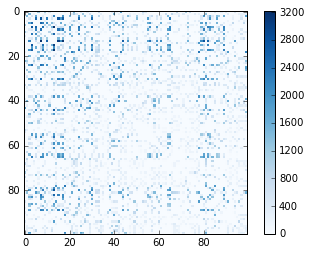

In [15]:
plt.imshow(-mergeability,cmap='Blues',interpolation='none')
plt.colorbar()

In [16]:
(mergeability[mergeability!=0]).flatten()

array([-1210.95584781, -1170.27968114,  -434.664017  , ...,  -247.38584462,
        -351.55224311,  -290.94277377])

In [17]:
x = np.random.rand(10,2)
x.sum(1)

array([ 1.3818976 ,  0.93628621,  1.32130625,  1.40040968,  1.10776144,
        0.48191588,  0.96551644,  0.08987436,  1.64395778,  0.76521855])

In [18]:
x / x.sum(1)[:,None]

array([[ 0.61679231,  0.38320769],
       [ 0.40646863,  0.59353137],
       [ 0.6739073 ,  0.3260927 ],
       [ 0.4981113 ,  0.5018887 ],
       [ 0.53268458,  0.46731542],
       [ 0.71496235,  0.28503765],
       [ 0.75690651,  0.24309349],
       [ 0.83830958,  0.16169042],
       [ 0.41611913,  0.58388087],
       [ 0.85901135,  0.14098865]])

In [19]:
def fractional_metastability(T):
    return np.trace(T)/len(T)

def product_of_fractional_metastabilities(Ts):
    return np.prod([fractional_metastability(T) for T in Ts])

In [20]:
class RoseTree(object):
    # says which indices are lumped at which level
    
    def __init__(self,children):
        self.children = children
        
    def leaves(self):
        leaf_list = []

        for child in self.children:
            if type(child)==RoseTree:
                for leaf in child.leaves():
                    leaf_list.append(leaf)
            else:
                leaf_list.append(child)
        return leaf_list
    
def join(a,b):
    return RoseTree([a,b])

def absorb(a,b):
    a.children.append(b)

def collapse(a,b):
    return RoseTree(a.children+b.children)

In [21]:
T_0 = RoseTree([RoseTree([i]) for i in range(n)])

In [22]:
T = T_0.children[0]
while len(T_0.children)>0:
    T = join(T_0.children.pop(),T)

In [23]:
np.trace(msm.transition_matrix)/n

0.24524941261065283

In [24]:
from sklearn.cluster import SpectralBiclustering
bic = SpectralBiclustering(6)
bic.fit(msm.transition_matrix)

In [25]:
msm.transition_matrix.shape

(100, 100)

In [26]:
def cg_T(microstate_T, microstate_pi, cg_map):
    ''' Coarse-grain a microstate transition matrix by applying cg_map
    Parameters
    ----------
    microstate_T : (N,N), array-like, square
     microstate transition matrix
    microstate_pi : (N,), array-like
     microstate stationary distribution
    cg_map : (N,), array-like
     assigns each microstate i to a macrostate cg_map[i]
    Returns
    -------
    T : numpy.ndarray, square
     macrostate transition matrix
    '''

    n_macrostates = np.max(cg_map)+1
    n_microstates = len(microstate_T)

    # compute macrostate stationary distribution
    macrostate_pi = np.zeros(n_macrostates)
    for i in range(n_microstates):
        macrostate_pi[cg_map[i]] += microstate_pi[i]
    macrostate_pi /= np.sum(macrostate_pi)

    # accumulate macrostate transition matrix
    T = np.zeros((n_macrostates,n_macrostates))
    for i in range(n_microstates):
        for j in range(n_microstates):
            T[cg_map[i],cg_map[j]] += microstate_pi[i] * microstate_T[i,j]

    # normalize
    for a in range(n_macrostates):
        T[a] /= macrostate_pi[a]
    
    return T

In [27]:
T = msm.transition_matrix
pi = msm.stationary_distribution
macro_T = cg_T(T,pi,bic.row_labels_)

In [28]:
fractional_metastability(macro_T)

0.93118665441309789

In [29]:
fractional_metastability(T[bic.row_labels_==0][:,bic.row_labels_==0])

0.30504616277307373

In [30]:
fractional_metastability(T[bic.row_labels_==1][:,bic.row_labels_==1])

0.20393500532082995

In [31]:
fractional_metastability(T[bic.row_labels_==2][:,bic.row_labels_==2])

0.25364616934373213

In [32]:
np.trace(T)

24.524941261065283

In [33]:
np.prod([np.trace(T[bic.row_labels_==i][:,bic.row_labels_==i]) for i in range(3)])

88.363656696114163

In [34]:
dumb_labels = np.zeros(n)
dumb_labels[n/2:] = 1

In [35]:
np.prod([np.trace(T[dumb_labels==i][:,dumb_labels==i]) for i in range(2)])

148.23548024774706

In [36]:
np.trace(T[dumb_labels==0][:,dumb_labels==0])

13.722849251619847

In [37]:
np.trace(T[dumb_labels==1][:,dumb_labels==1])

10.802092009445438

In [38]:
def plot_contiguous(T,mapping):
    sorted_inds = np.array(sorted(range(len(T)),key=lambda i:mapping[i]))
    plt.imshow(T[sorted_inds][:,sorted_inds],interpolation='none',cmap='Blues')
    plt.colorbar()

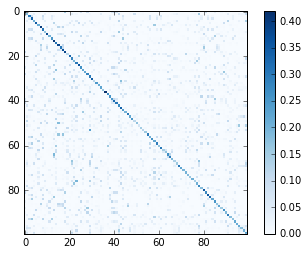

In [39]:
plot_contiguous(T,dumb_labels)

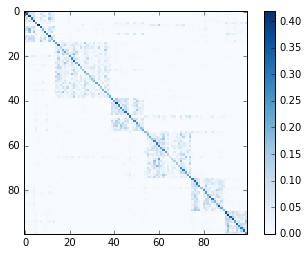

In [40]:
plot_contiguous(T,bic.row_labels_)

In [41]:
submatrix = lambda i:T[bic.row_labels_==i][:,bic.row_labels_==i]
T_0 = submatrix(5)

In [42]:
bic2 = SpectralBiclustering(2)
bic2.fit(T_0)
bic2.row_labels_

array([1, 0, 1, 1, 1, 0, 0, 0, 0, 1], dtype=int32)

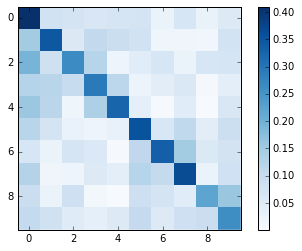

In [43]:
plot_contiguous(T_0,bic2.row_labels_)

In [44]:
macro_Ts = []
Ns = range(2,30)

for i in Ns:
    bic = SpectralBiclustering(i)
    bic.fit(msm.transition_matrix)
    macro_T = cg_T(T,pi,bic.row_labels_)
    macro_Ts.append(macro_T)

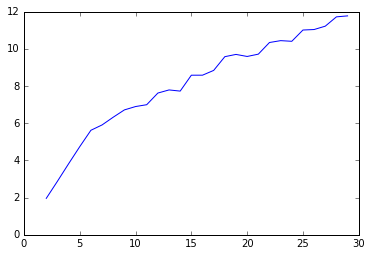

In [45]:
plt.plot(Ns,[np.trace(t) for t in macro_Ts])

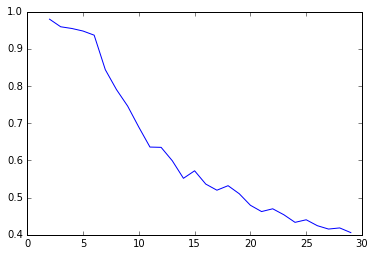

In [46]:
plt.plot(Ns,[np.trace(t)/len(t) for t in macro_Ts])

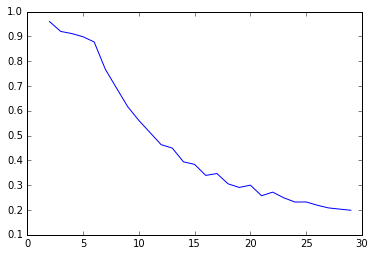

In [47]:
plt.plot(Ns,[np.trace(t**2) / (len(t)) for t in macro_Ts])

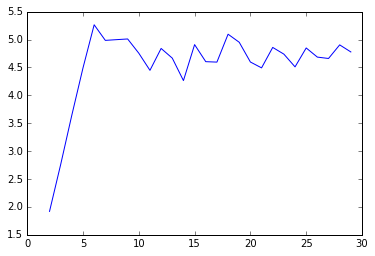

In [56]:
plt.plot(Ns,[np.trace(t)**2 / (len(t)) for t in macro_Ts])

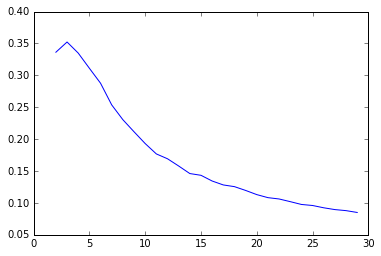

In [48]:
plt.plot(Ns,[np.log(np.trace(t)) /(len(t)) for t in macro_Ts])

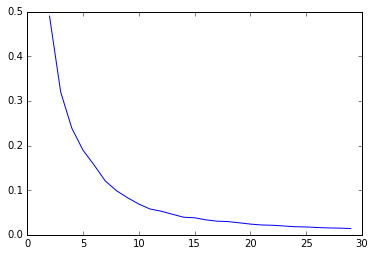

In [49]:
plt.plot(Ns,[np.trace(t)/(len(t)**2) for t in macro_Ts])

In [50]:
np.linalg.norm(T-np.diag(np.diag(T)))

2.2725294352316356

In [51]:
np.trace(T)

24.524941261065283

In [52]:
np.sum(msm.count_matrix_active)

99989.0

In [53]:
np.trace(msm.count_matrix_active)/np.sum(msm.count_matrix_active)

0.27840062406864757

In [54]:
np.sum(msm.count_matrix_active[dumb_labels==0][:,dumb_labels==0])

43326.0

In [55]:
msm.count_matrix_active

array([[ 361.,    0.,    0., ...,    0.,    0.,    2.],
       [   0.,  160.,    3., ...,   15.,    5.,   93.],
       [   0.,    2.,  420., ...,   13.,    0.,    5.],
       ..., 
       [   0.,   15.,   14., ...,   40.,    8.,    7.],
       [   0.,    8.,    5., ...,    8.,   66.,    8.],
       [   0.,   91.,    2., ...,    4.,   13.,  340.]])

In [63]:
likelihood_unnorm = np.prod(msm.transition_matrix**msm.count_matrix_active)
likelihood_unnorm

0.0

In [64]:
np.min(msm.transition_matrix**msm.count_matrix_active)

0.0

In [82]:
msm = pyemma.msm.BayesianMSM(1,nsamples=1000)
msm.fit(dtrajs)

Sampling MSMs: 100% (1000/1000) [##################################] eta 00:00 \

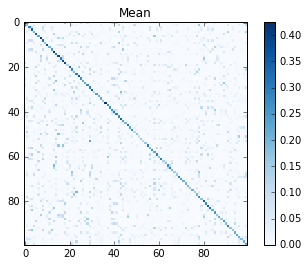

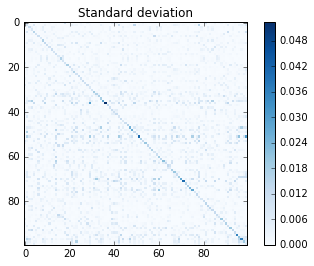

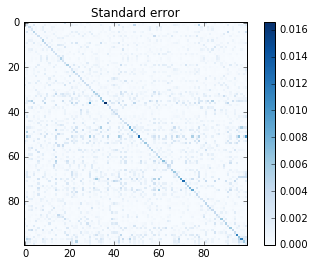

In [83]:
mats = np.array([m.transition_matrix for m in msm.samples[:10]])

plt.imshow(mats.mean(0),interpolation='none',cmap='Blues')
plt.title('Mean')
plt.colorbar()

plt.figure()
stdev = mats.std(0)
plt.imshow(stdev,interpolation='none',cmap='Blues')
plt.title('Standard deviation')
plt.colorbar()

plt.figure()
stderr = mats.std(0)/np.sqrt(len(mats))
plt.imshow(stderr,interpolation='none',cmap='Blues')
plt.title('Standard error')
plt.colorbar()

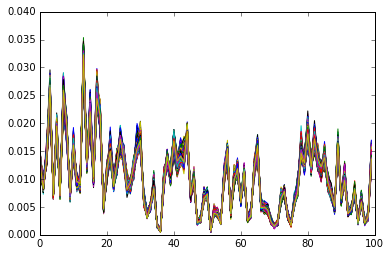

In [86]:
for sample in msm.samples:
    plt.plot(sample.pi)

In [87]:
stat_dists=np.array([sample.pi for sample in msm.samples])

In [90]:
stat_dists.mean(0).shape

(100,)

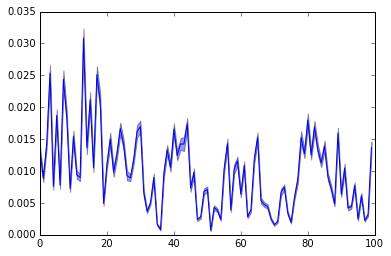

In [93]:
plt.plot(stat_dists.mean(0))

stderr = stat_dists.std(0)#/msm.nsamples
plt.fill_between(np.arange(msm.nstates),stat_dists.mean(0)+stderr,stat_dists.mean(0)-stderr,alpha=0.4)

In [95]:
np.argmax(stat_dists.std(0)/stat_dists.mean(0))

36

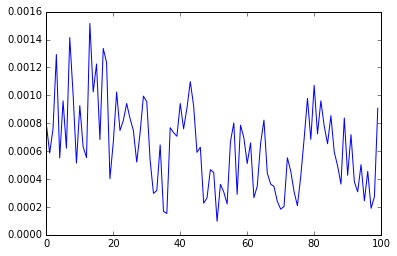

In [98]:
plt.plot(stat_dists.std(0))

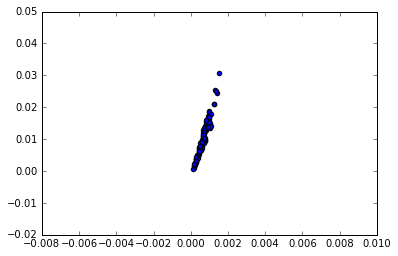

In [99]:
plt.scatter(stat_dists.std(0),stat_dists.mean(0))

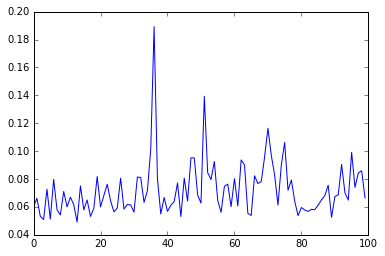

In [97]:
plt.plot(stat_dists.std(0)/stat_dists.mean(0))